In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import torch
import dill
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pyloric import summary_stats, simulate, create_prior
from paper.pyloric_utils import compare_voltage_low_and_high_energy_trace
from sbi.analysis import pairplot, marginal_plot
from sbi.utils.posterior_ensemble import NeuralPosteriorEnsemble
from sbi.utils.sbiutils import ImproperEmpirical

# Panel A

In [3]:
xo = torch.as_tensor(
    [
        1.17085859e03,
        2.06036434e02,
        2.14307031e02,
        4.12842187e02,
        1.75970382e-01,
        1.83034085e-01,
        3.52597820e-01,
        4.11600328e-01,
        6.30544893e-01,
        4.81925781e02,
        2.56353125e02,
        2.75164844e02,
        4.20460938e01,
        2.35011166e-01,
        3.59104797e-02,
        2.5,
        2.5,
        2.5,
    ]
)
prior = create_prior().numerical_prior
lower = prior.support.base_constraint.lower_bound
upper = prior.support.base_constraint.upper_bound
limits = torch.stack([lower, upper]).T
p = create_prior()
names = p.sample((1,)).columns
unconstrained_prior = ImproperEmpirical(torch.rand(100, 31), torch.ones(100))

In [6]:
with open("../../../l5pc/results/p31_4/multiround/2022_05_17__01_40_01__multirun/0/inference_r13.pkl", "rb") as handle:
    inference_tsnpe_r13 = pickle.load(handle)
posterior_tsnpe_r13 = inference_tsnpe_r13[0].build_posterior().set_default_x(xo)
_ = torch.manual_seed(1)
samples_tsnpe_r13 = posterior_tsnpe_r13.sample((100000,))

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [7]:
mins, _ = torch.min(samples_tsnpe_r13, dim=0)
maxs, _ = torch.max(samples_tsnpe_r13, dim=0)
maxs_minus_mins = maxs - mins
limit_range = upper - lower
fractions = maxs_minus_mins / limit_range
torch.prod(fractions)

tensor(0.9447)

In [8]:
prior = create_prior(as_torch_dist=True)
lower_bound = prior.support.base_constraint.lower_bound
upper_bound = prior.support.base_constraint.upper_bound
prior_pd = create_prior()
lims = np.asarray([lower_bound.numpy(), upper_bound.numpy()]).T

In [9]:
from sbi.utils.support_posterior import PosteriorSupport

In [10]:
posterior_support = PosteriorSupport(
    prior,
    posterior_tsnpe_r13,
    num_samples_to_estimate_support=100000,
    allowed_false_negatives=0.0001,
    use_constrained_prior=False,
)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
_ = posterior_support.sample((10,))

The classifier rejected 99.9450% of all samples. You will get a speed-up of 181718.2%.


In [13]:
def get_labels_8pt(mathmode=False, log_syns=False, include_q10=True):
    # membrane_conds = np.asarray(params.use_membrane)
    membrane_names = [
        ["AB-Na", "AB-CaT", "AB-CaS", "AB-A", "AB-KCa", "AB-Kd", "AB-H", "AB-leak"],
        ["LP-Na", "LP-CaT", "LP-CaS", "LP-A", "LP-KCa", "LP-Kd", "LP-H", "LP-leak"],
        ["PY-Na", "PY-CaT", "PY-CaS", "PY-A", "PY-KCa", "PY-Kd", "PY-H", "PY-leak"],
    ]
    if mathmode:
        membrane_names = [
            [
                r"$\mathrm{AB}_\mathrm{Na}$",
                r"$\mathrm{AB}_\mathrm{CaT}$",
                r"$\mathrm{AB}_\mathrm{CaS}$",
                r"$\mathrm{AB}_\mathrm{A}$",
                r"$\mathrm{AB}_\mathrm{KCa}$",
                r"$\mathrm{AB}_\mathrm{Kd}$",
                r"$\mathrm{AB}_\mathrm{H}$",
                r"$\mathrm{AB}_\mathrm{leak}$",
            ],
            [
                r"$\mathrm{LP}_\mathrm{Na}$",
                r"$\mathrm{LP}_\mathrm{CaT}$",
                r"$\mathrm{LP}_\mathrm{CaS}$",
                r"$\mathrm{LP}_\mathrm{A}$",
                r"$\mathrm{LP}_\mathrm{KCa}$",
                r"$\mathrm{LP}_\mathrm{Kd}$",
                r"$\mathrm{LP}_\mathrm{H}$",
                r"$\mathrm{LP}_\mathrm{leak}$",
            ],
            [
                r"$\mathrm{PY}_\mathrm{Na}$",
                r"$\mathrm{PY}_\mathrm{CaT}$",
                r"$\mathrm{PY}_\mathrm{CaS}$",
                r"$\mathrm{PY}_\mathrm{A}$",
                r"$\mathrm{PY}_\mathrm{KCa}$",
                r"$\mathrm{PY}_\mathrm{Kd}$",
                r"$\mathrm{PY}_\mathrm{H}$",
                r"$\mathrm{PY}_\mathrm{leak}$",
            ],
        ]
    membrane_names = np.asarray(membrane_names)
    relevant_membrane_names = membrane_names
    synapse_names = np.asarray(
        [pick_synapse(num, True, log_syns=log_syns) for num in range(7)]
    )
    relevant_labels = np.concatenate((relevant_membrane_names.flatten(), synapse_names))
    # q10_names = [u'Q_{10} g\u0305_{glut}', u'Q_{10} g\u0305_{chol}', r'Q_{10} \tau_{glut}', r'Q_{10} \tau_{chol}']
    if include_q10:
        q10_names = [
            r"$\mathrm{Q}_{\mathrm{10}} \mathrm{Na}$",
            r"$\mathrm{Q}_{\mathrm{10}} \mathrm{CaT}$",
            r"$\mathrm{Q}_{\mathrm{10}} \mathrm{CaS}$",
            r"$\mathrm{Q}_{\mathrm{10}} \mathrm{CaA}$",
            r"$\mathrm{Q}_{\mathrm{10}} \mathrm{KCa}$",
            r"$\mathrm{Q}_{\mathrm{10}} \mathrm{Kd}$",
            r"$\mathrm{Q}_{\mathrm{10}} \mathrm{H}$",
            r"$\mathrm{Q}_{\mathrm{10}} \mathrm{leak}$",
            r"$\mathrm{Q}_{\mathrm{10}} \mathrm{glut}$",
            r"$\mathrm{Q}_{\mathrm{10}} \mathrm{chol}$",
        ]
        relevant_labels = np.concatenate((relevant_labels, q10_names))

    return relevant_labels

# get the title of the synapses
def pick_synapse(num, mathmode=False, log_syns=False):
    if log_syns:
        if mathmode:
            if num == 0:
                return r"$\mathdefault{log(AB-LP)}$"
            if num == 1:
                return r"$\mathdefault{log(PD-LP)}$"
            if num == 2:
                return r"$\mathdefault{log(AB-PY)}$"
            if num == 3:
                return r"$\mathdefault{log(PD-PY)}$"
            if num == 4:
                return r"$\mathdefault{log(LP-PD)}$"
            if num == 5:
                return r"$\mathdefault{log(LP-PY)}$"
            if num == 6:
                return r"$\mathdefault{log(PY-LP)}$"
        else:
            if num == 0:
                return "AB-LP"
            if num == 1:
                return "PD-LP"
            if num == 2:
                return "AB-PY"
            if num == 3:
                return "PD-PY"
            if num == 4:
                return "LP-PD"
            if num == 5:
                return "LP-PY"
            if num == 6:
                return "PY-LP"
    else:
        if mathmode:
            if num == 0:
                return r"$\mathdefault{AB-LP}$"
            if num == 1:
                return r"$\mathdefault{PD-LP}$"
            if num == 2:
                return r"$\mathdefault{AB-PY}$"
            if num == 3:
                return r"$\mathdefault{PD-PY}$"
            if num == 4:
                return r"$\mathdefault{LP-PD}$"
            if num == 5:
                return r"$\mathdefault{LP-PY}$"
            if num == 6:
                return r"$\mathdefault{PY-LP}$"
        else:
            if num == 0:
                return "AB-LP"
            if num == 1:
                return "PD-LP"
            if num == 2:
                return "AB-PY"
            if num == 3:
                return "PD-PY"
            if num == 4:
                return "LP-PD"
            if num == 5:
                return "LP-PY"
            if num == 6:
                return "PY-LP"

In [30]:
from decimal import Decimal
all_labels = []
for dim_i in range(31):
    if dim_i > 31 - 7.5: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}\;\;\;\;\;\;\;\;\;$           ', r'$\mathdefault{10000}\;\;\;\;\;\;$    '])
        else: all_labels.append([r'$\;\;\mathdefault{0.01}\;\;\;\;\;\;\;$         ', r'$\mathdefault{1000}\;\;\;\;\;$  '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims[dim_i, 1]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round((lims[dim_i, num_tmp]), num_after_digits) if lims[dim_i, num_tmp] < 1.0 else int(lims[dim_i, num_tmp])
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$      ')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$   ')
            counter+=1
        all_labels.append(new_labels)

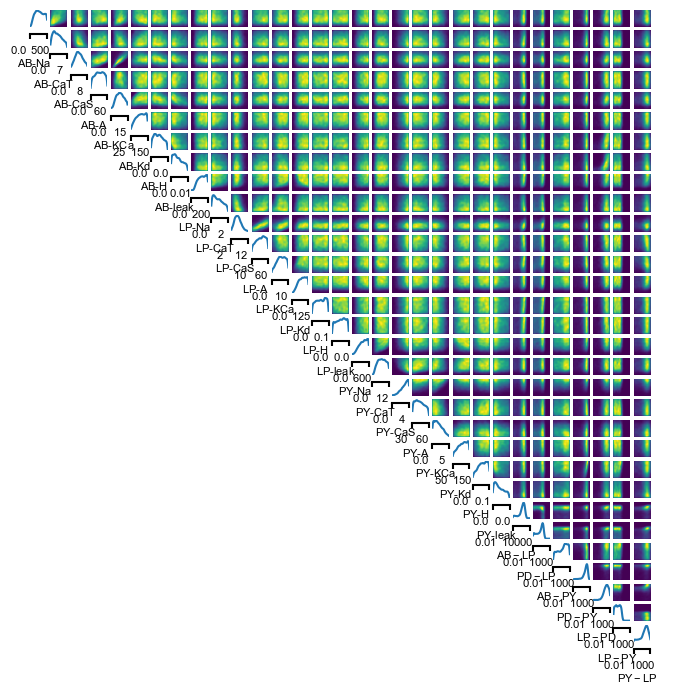

In [31]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    new_labels = []
    for l in labels_:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_ = new_labels
    labels_[9] += ''

    fig, axes = pairplot(
        samples=[samples_tsnpe_r13[:10000]],
        labelpad=1,
        tick_labelpad=1,
        limits=lims,
        ticks=lims,
        tick_labels=all_labels,
        figsize=(8.0, 8.0),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        # samples_colors=[col['SNPE']],
        diag=['kde'],
        upper=['kde'],
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )

    plt.savefig('../svg/panel_appendix3.svg', facecolor='None', transparent=True)
    plt.show()

# APT

In [32]:
with open("/home/michael/Documents/tsnpe_collection/l5pc/results/p31_4/multiround/2022_05_14__23_49_35__multirun/0/inference_r13.pkl", "rb") as handle:
    inference_apt_r13 = pickle.load(handle)
posterior_apt_r13 = inference_apt_r13[0].build_posterior().set_default_x(xo)
_ = torch.manual_seed(2)
samples_apt_r13 = posterior_apt_r13.sample((10000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

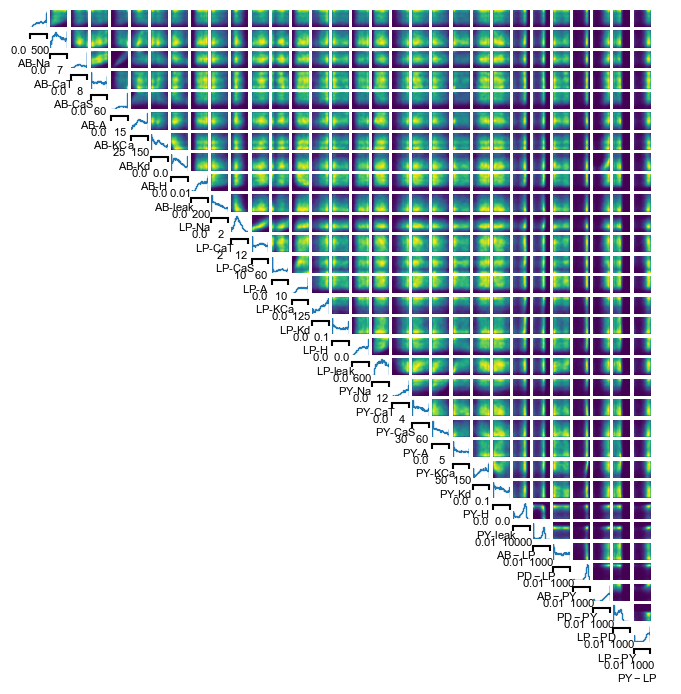

In [33]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    new_labels = []
    for l in labels_:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_ = new_labels
    labels_[9] += ''

    fig, axes = pairplot(
        samples=[samples_apt_r13[:10000]],
        labelpad=1,
        tick_labelpad=1,
        limits=lims,
        ticks=lims,
        tick_labels=all_labels,
        figsize=(8.0, 8.0),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        # samples_colors=[col['SNPE']],
        diag=['hist'],
        upper=['kde'],
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )

    plt.savefig('../svg/panel_appendix6.svg', facecolor='None', transparent=True)
    plt.show()

## Assemble figure

In [34]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [35]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

sizefactor = 1.0

f = Figure("15.7cm", "17.3cm",
    Panel(
          SVG("../svg/panel_appendix3.svg").scale(svg_scale),
    ).move(5, 5),
    
)

!mkdir -p fig
f.save("../fig/fig7_appendix3.svg")
svg('../fig/fig7_appendix3.svg')

In [36]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

sizefactor = 1.0

f = Figure("15.7cm", "17.3cm",
    Panel(
          SVG("../svg/panel_appendix6.svg").scale(svg_scale),
    ).move(5, 5),
    
)

!mkdir -p fig
f.save("../fig/fig7_appendix6.svg")
svg('../fig/fig7_appendix6.svg')